In [1]:
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
feature = pd.read_pickle('./corpus/corax_features.pkl')
label = pd.read_pickle('./corpus/corax_labels.pkl')
adj_matrix=pd.read_pickle('./corpus/corax_adj.pkl')

In [3]:
# feature是一个numpy数组，只要feature的前300维
#feature = feature[:, :300]
print(feature.shape)
print(label)

(2680, 302)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
label_onehot = torch.tensor(label)
#One-Hot编码转换为0-6
y = torch.topk(label_onehot, 1)[1].squeeze(1).numpy()
y.shape

(2680,)

In [5]:
adj_matrix

<2680x2680 sparse matrix of type '<class 'numpy.int64'>'
	with 10296 stored elements in Compressed Sparse Row format>

In [6]:
#根据邻接矩阵确定连边关系
G = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph())
print(G)

DiGraph with 2680 nodes and 10296 edges


In [7]:
# 迭代所有结点，计算结点入度出度及图特征
inDeg = G.in_degree()
outDeg = G.out_degree()
# 验证是否为有向图
print(G.is_directed())
degree_centrality = nx.degree_centrality(G)
page_rank = nx.pagerank(G)
clustering = nx.clustering(G)
eigen = nx.eigenvector_centrality(G)

# 所有特征合并为一个矩阵
feature_matrix = np.zeros((len(inDeg), 6))
for i in range(len(inDeg)):
    feature_matrix[i, 4] = inDeg[i]
    feature_matrix[i, 5] = outDeg[i]
    feature_matrix[i, 0] = degree_centrality[i]
    feature_matrix[i, 1] = page_rank[i]
    feature_matrix[i, 2] = clustering[i]
    feature_matrix[i, 3] = eigen[i]

# 标准化
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)
    
# 特征拼接
use_node_attr = False
if use_node_attr == True:
    feature = np.c_[feature, feature_matrix]
else:
    feature = feature


True


d:\Install\Anaconda\envs\ml-labs\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
d:\Install\Anaconda\envs\ml-labs\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


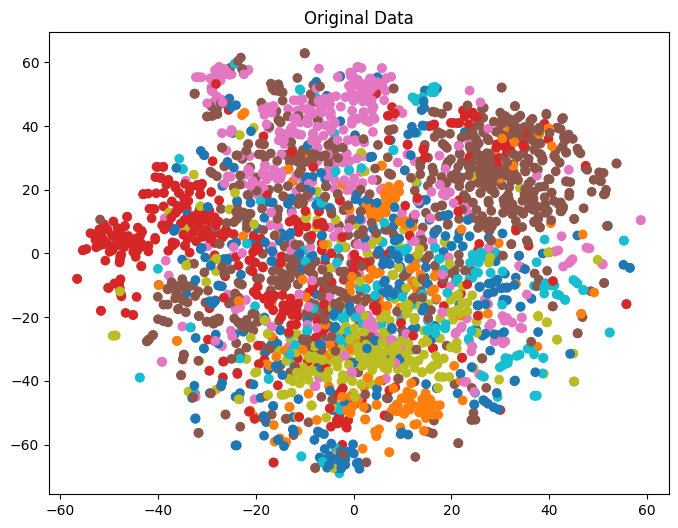

In [8]:
from sklearn.manifold import TSNE
# 对特征数据进行 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', metric='euclidean')
features_tsne = tsne.fit_transform(feature)

# 绘制原始数据的散点图
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=label.argmax(axis=1),cmap='tab10')
plt.title('Original Data')
plt.show()

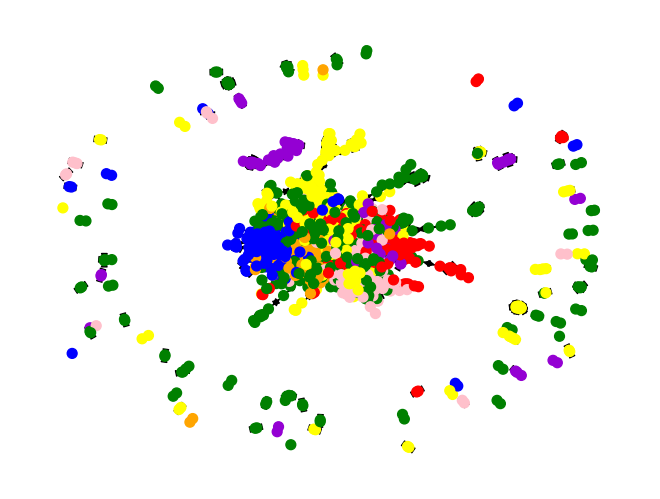

In [9]:
# Cora有7个类别，对应7个颜色
color = ['red', 'orange', 'blue', 'green', 'yellow', 'pink', 'darkviolet']

# 每个节点对应的颜色
node_color = [color[y[i]] for i in range(len(G.nodes))]

pos = nx.spring_layout(G)
# 绘制图
nx.draw(G, pos,node_size=50, node_color=node_color)
plt.show()


In [10]:
Cora_train = np.c_[feature[0:1180],y[0:1180]]
Cora_validation = np.c_[feature[1180:1680],y[1180:1680]]
Cora_test = np.c_[feature[1680:2681],y[1680:2681]]

Cora_train=pd.DataFrame(Cora_train)
Cora_validation=pd.DataFrame(Cora_validation)
Cora_test=pd.DataFrame(Cora_test)

In [ ]:
Cora_train.to_pickle('./processed/corax_train.pkl')
Cora_validation.to_pickle('./processed/corax_validation.pkl')
Cora_test.to_pickle('./processed/corax_test.pkl')
nx.write_gpickle(G,'./processed/corax_graph.gpickle')